#### Imports & Functions

In [1]:
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from itertools import repeat, chain
import shap
from shap import TreeExplainer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def plot_aocs(df):
    for i in range(len(df)):
        plt.plot(df.iloc[i,0], df.iloc[i,1])
    x = np.linspace(0,1, 100000)
    plt.plot(x, x, linestyle='--')

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(df.index)

def get_genre_aggregations(df, genres, aggs, suffix=''):    
    agg_dfs = ([(df[df[genre]==1].groupby(['reader_id'], as_index=False)
                                 .agg(aggs)
                                 .set_index('reader_id')) for genre in genres])
    genre_agg_df = pd.concat(agg_dfs, axis=1)
    genre_agg_df.columns = [genre + suffix for genre in genres]
    return genre_agg_df
def test_features_basic_xgb(df, aoc = False, label = '', save_model=False):
    X_train, X_test, y_train, y_test = (train_test_split(df.iloc[:,1:],df.rating,test_size=0.15, random_state=42))
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
    gbm = (xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=6,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        use_label_encoder=False
                       ))
    eval_set=[(X_train,y_train),(X_val,y_val)]
    gbm_fit = (gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='logloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   ))
    print(f'F1 score: {f1_score(y_test, gbm.predict(X_test))}')
    print(f'Confusion Matrix:')
    print(confusion_matrix(y_test, gbm.predict(X_test)))
    if aoc==True:
        fpr, tpr, _ = roc_curve(y_test, gbm_fit.predict(X_test))
        roc_df.loc[label] = [fpr, tpr]
    if save_model == True:
        return X_test, y_test, gbm_fit
def get_reader_split_data(df, index_id=True, test_size=.2, seed=123):
    rs = np.random.RandomState(seed)
    if index_id==True:
        total_readers = df.index
        test_readers = rs.choice(total_readers, size=int(total_readers.shape[0] * test_size), replace=False)
        df_tr, df_te = df[~df.index.isin(test_readers)], df[df.index.isin(test_readers)]
    else:
        total_readers = readers['reader_id'].unique()
        test_readers = rs.choice(total_readers, size=int(total_readers.shape[0] * test_size), replace=False)
        df_tr = df[~df['reader_id'].isin(test_readers)], df[df['reader_id'].isin(test_readers)]
    y_tr, y_te = df_tr['rating'], df_te['rating']
    X_tr, X_te = df_tr.drop(columns=['rating']), df_te.drop(columns=['rating'])
    return X_tr, X_te, y_tr, y_te
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
def get_rankings(item, df):
    item_count_dict = {}
    # For every tag in df
    for i in range(df.shape[1]):    
        # Calculate % of cases that tagged the item
        val_counts = df.iloc[:,i].value_counts(normalize = True)
        if item in val_counts.index:
            item_counts = val_counts[item]
        else:
            item_counts = 0
        # Add score to dict
        item_count_dict["tag_{}".format(i)] = item_counts
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [4]:
def get_dist_perc(x):
    star = int(x['reader_rating']-1)
    return ( (x[stars[star]]/2) + x[stars[:star]].sum() ) / x[stars].sum()
def get_likelihood(x):
    star = int(x['reader_rating']-1)
    return x[stars[star]] / x[stars].sum()
def get_median(x):
    median = x[stars].sum()/2
    for star in range(1,6):
        if median <= x[stars[:int(star)]].sum():
            return star

In [5]:
readers_books = pd.read_csv('Data/readers_books.csv')
readers = pd.read_csv('Data/readers.csv').drop_duplicates().dropna() #some readers did not rate the book
readers = readers[readers.reader_id.isin(readers_books.reader_id)] # Filter out readers with private profiles
readers_books = readers_books[(readers_books.reader_id.isin(readers.reader_id))&(readers_books.book_id!=1162022)]

#### Reader Level Features EDA

In [6]:
#readers_books['read_at'] = pd.to_datetime(readers_books['read_at'])
#readers_books['started_at'] = pd.to_datetime(hist['started_at'])
#readers_books['reading_time'] = readers_books['read_at'] - readers_books['started_at']
#readers_books.reading_time.mean()
readers_books.drop(columns=['started_at','read_at'], inplace=True, errors='ignore')
readers_books['rating_bias'] = readers_books['reader_rating'] - readers_books['book_avg_rating']

In [7]:
reader_features = (['reader_avg_publ_year', 'reader_avg_rating', 'reader_avg_book_length',
                    'reader_avg_book_rating','reader_avg_rating bias', 'reader_avg_book_popularity',])

df_reader_feats=(readers_books.groupby(['reader_id'],as_index=False).agg(OrderedDict([('book_year','mean'),
                                                                                    ('reader_rating', 'mean'),
                                                                                    ('book_avg_rating', 'mean'),
                                                                                    ('book_nr_pages', 'mean'),
                                                                                    ('rating_bias', 'mean'),
                                                                                    ('book_nr_ratings', 'mean')])))
df_reader_feats.columns = ['reader_id'] + reader_features

#df_reader_feats['reader_med_reading_time'] = df_reader_feats.reader_med_reading_time.dt.days
#df_reader_feats = df_reader_feats.drop(columns=['reader_med_reading_time'])

In [8]:
df_X = df_reader_feats.merge(readers, how='inner', on='reader_id')
# Convert rating to target                                         
df_X['rating'] = df_X.rating.apply(lambda x: x>=4).astype(int)
df_X['reader_avg_publ_year'] = df_X.reader_avg_publ_year.fillna(df_X.reader_avg_publ_year.mean())
df_X = df_X.dropna()

In [9]:
#sns.pairplot(df_X.loc[:,1:], hue='target', plot_kws=dict(alpha=.3, edgecolor='none'))

Look at proportion of 'older' books as a potential feature

In [10]:
#test = readers_books.iloc[:,[1,4,7,-1]].merge(readers, how='inner', on='reader_id')
#test = test[(test.book_year>1400)&(test.book_year<2024)]
#test['target'] = (test.rating>=4).astype('int')
#test['old'] = (test.book_year<2005).astype('int')
#test = test.groupby('reader_id').agg({'old':'mean','target':'mean'})
#sns.pairplot(test_old, hue='target')

Look at books' popularity and if there is separation

In [11]:
#test = readers_books.iloc[:,[-2,-3]]
#test['pop_books'] = (test.book_nr_ratings>2000000).astype('int')
#test['very_pop_books'] = (test.book_nr_ratings>4000000).astype('int')
#test = ((test.groupby('reader_id', as_index=False).agg({'very_pop_books':'mean','pop_books':'mean'}))
#        .merge(readers, on='reader_id', how='left'))
#test.loc[:,'rating'] = (test.rating>=4).astype('int')
#sns.pairplot(test.iloc[:,1:], hue='rating')

#### Baseline Models

In [12]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]
X_tr, X_te, y_tr, y_te = get_reader_split_data(df_X)
fit_models = []
models_metrics = []
for model in models:
    init = model
    init.fit(X_tr, y_tr)
    fit_models.append(model)
for fit_model in fit_models:
    y_pred = fit_model.predict(X_te)
    metrics = (OrderedDict([('Model', str(models[fit_models.index(fit_model)])),
                            ('Precision', precision_score(y_te, y_pred)),
                            ('Recall', recall_score(y_te, y_pred)),
                            ('F1', f1_score(y_te, y_pred))]))
    models_metrics.append(metrics)

In [13]:
std = StandardScaler()
std.fit(X_tr)
X_tr_sc, X_te_sc = std.transform(X_tr), std.transform(X_te) 

knn = KNeighborsClassifier().fit(X_tr_sc, y_tr)
fit_models.append(knn)
y_pred = knn.predict(X_te_sc)
models_metrics.append(OrderedDict([('Model', 'KNeighbors()'), ('Precision', precision_score(y_te, y_pred)),
                            ('Recall', recall_score(y_te, y_pred)), ('F1', f1_score(y_te, y_pred))]))

<AxesSubplot:xlabel='variable', ylabel='value'>

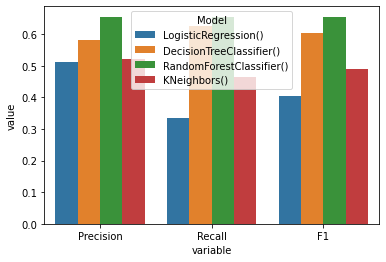

In [14]:
models_metrics_df = pd.melt(pd.DataFrame(models_metrics), id_vars=['Model'])
sns.barplot(y='value', x='variable', hue='Model', data=models_metrics_df)

In [15]:
roc_df = pd.DataFrame(columns=['fpr','tpr'])
for fit_model in fit_models[:-1]:
    fpr, tpr, _ = roc_curve(y_te, fit_model.predict_proba(X_te)[:,1])
    roc_df.loc[str(fit_model)] = [fpr, tpr]
fpr, tpr, _ = roc_curve(y_te, fit_models[-1].predict_proba(X_te_sc)[:,1])
roc_df.loc[str(fit_models[-1])] = [fpr, tpr]

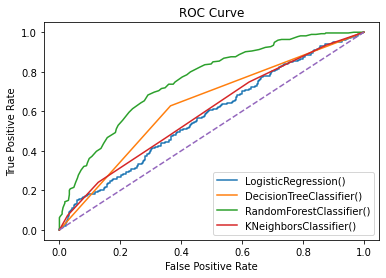

In [16]:
plot_aocs(roc_df)

In [17]:
#sns.pairplot(df_X.iloc[:,1:], hue='rating')
#X_test, y_test, gbm = test_features_basic_xgb(df_X.iloc[:,[-1,1,2,3,4,5,6]], save_model=True)
#exp = TreeExplainer(gbm)
#shap_vals = exp.shap_values(X_test)
#shap.summary_plot(shap_vals, X_test) #We can confirm that reader_avg_book_rating and reader_avg_book_popularity
                                        # are not good features due to lack of separability

In [18]:
df_X = df_X.drop(columns=['reader_avg_book_rating', 'reader_avg_book_popularity'])

### Genres Features Data Wrangling

In [19]:
readers = pd.read_csv('Data/readers.csv').drop_duplicates()
readers_books = pd.read_csv('Data/readers_books.csv')
books = pd.read_csv('Data/Books/all_books.csv')

readers = pd.read_csv('Data/readers.csv').drop_duplicates().dropna() #some readers did not rate the book
readers_books = readers_books[(readers_books.reader_id.isin(readers.reader_id))&(readers_books.book_id!=1162022)]
readers = readers[readers.reader_id.isin(readers_books.reader_id)] # Filter out readers with private profiles
# The target book rating in reading hist should not be used to train the model. 

In [20]:
# Get books' rating distribution
books_stars = books.iloc[:,[1,-1]]
books_stars["rating_distribution"] = books_stars["rating_distribution"].apply(eval)
stars = ['1 Star','2 Stars','3 Stars','4 Stars','5 Stars']
for star in stars:
    books_stars[star] = books_stars.loc[:,'rating_distribution'].apply(lambda x: x[star])
books_stars['book_median'] = books_stars.apply(get_median, axis=1)
books_stars.head(2)

,book_id,rating_distribution,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,book_median
0,45023611,"{'5 Stars': 8454, '4 Stars': 16217, '3 Stars':...",824,3067,12083,16217,8454,4
1,13662,"{'5 Stars': 38599, '4 Stars': 39593, '3 Stars'...",1302,3514,18726,39593,38599,4


In [21]:
readers_books_dist = (readers_books.loc[:,['reader_id','reader_rating','book_id','book_avg_rating']]
                      .merge(books_stars.drop(columns=['rating_distribution']), on='book_id', how='inner'))
readers_books_dist['rating_percentile'] = readers_books_dist.apply(get_dist_perc, axis=1)
readers_books_dist['rating_likelihood'] = readers_books_dist.apply(get_likelihood, axis=1)
readers_books_dist['bias_median'] = readers_books_dist.reader_rating - readers_books_dist.book_median
readers_books_dist['bias_mean'] = readers_books_dist.reader_rating - readers_books_dist.book_avg_rating

In [23]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [24]:
readers_books_genres = (readers_books_dist.iloc[:,[0,1,2,3,10,11,12,13]]
                        .merge(books.iloc[:,[1,10]], on='book_id', how='inner'))
all_genres = to_1D(readers_books_genres.genres.apply(eval)).value_counts().drop('Audiobook').index

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

s = readers_books_genres['genres'].apply(eval)

mlb = MultiLabelBinarizer()

reader_genres = (pd.concat([
    readers_books_genres,
    pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=readers_books_genres.index)
    ], axis=1))

Baseline with few common genres (dropping NaNs)

In [26]:
baseline_df = (pd.concat([readers.set_index('reader_id'), get_genre_aggregations(reader_genres,
                                                                                 ['Romance','Young Adult','Fiction'],
                                                                                 {'bias_mean':'mean'})],
                         axis=1))
baseline_df['rating'] = (baseline_df.rating>=4).astype('int')
#sns.pairplot(bias_test, hue='rating')

In [27]:
X_tr, X_te, y_tr, y_te = get_reader_split_data(baseline_df.dropna())

rf = RandomForestClassifier().fit(X_tr, y_tr)
lr = LogisticRegression(C=100).fit(X_tr, y_tr)
ada = AdaBoostClassifier().fit(X_tr, y_tr)

std = StandardScaler().fit(X_tr)
X_tr_sc, X_te_sc = std.transform(X_tr), std.transform(X_te) 
knn = KNeighborsClassifier().fit(X_tr_sc, y_tr)

In [28]:
for fit_model in [rf, lr, ada]:
    fpr, tpr, _ = roc_curve(y_te, fit_model.predict_proba(X_te)[:,1])
    roc_df.loc[str(fit_model)+' 3 genres'] = [fpr, tpr]
fpr, tpr, _ = roc_curve(y_te, knn.predict_proba(X_te_sc)[:,1])
roc_df.loc['knn 3 genres'] = [fpr, tpr]

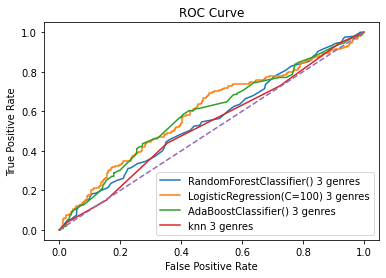

In [29]:
plot_aocs(roc_df.iloc[-4:])

#### Try all genres (with meaningful NaNs) on XGBoost

###### Divergence of user rating from book avg rating, aggregated by genre

In [30]:
div_from_mean = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, all_genres, {'bias_mean':'mean'},
                                                   ' mean')], axis=1, join='inner')
div_from_mean['rating'] = (div_from_mean.rating>=4.0).astype('int')

100 most common genres

In [31]:
test_features_basic_xgb(div_from_mean.iloc[:,:101], label='xgb mean top 100 gen', aoc=True)
#plot_aocs(roc_df.iloc[:-5])

F1 score: 0.5677083333333334
Confusion Matrix:
[[182  69]
 [ 97 109]]


All genres

In [32]:
test_features_basic_xgb(div_from_mean, label='xgb mean all gen', aoc=True)
#plot_aocs(roc_df.iloc[6:])           # Even with the dimensionality there is an improvement

F1 score: 0.5638297872340426
Confusion Matrix:
[[187  64]
 [100 106]]


Divergence of user rating from book avg rating, aggregated by genre

In [33]:
div_from_median = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, all_genres, {'bias_median':'mean'},
                                                   ' median')], axis=1, join='inner')
div_from_median['rating'] = (div_from_median.rating>=4.0).astype('int')

In [34]:
test_features_basic_xgb(div_from_median.iloc[:,:101], label='xgb median top 100 gen', aoc=True)
#plot_aocs(roc_df.iloc[-5:])

F1 score: 0.546875
Confusion Matrix:
[[178  73]
 [101 105]]


In [35]:
test_features_basic_xgb(div_from_median, label='xgb median all gen', aoc=True)
#plot_aocs(roc_df.iloc[-5:])

F1 score: 0.5606469002695419
Confusion Matrix:
[[190  61]
 [102 104]]


In [36]:
#div from median for some genres underperforms
# but div from median from all genres performs better than div from mean

Percentile within books'distributions, aggregated by genre

In [37]:
percentile = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, all_genres,{'rating_percentile':'mean'},
                                                   ' percentile')], axis=1, join='inner')
percentile['rating'] = (percentile.rating>=4.0).astype('int')

In [38]:
test_features_basic_xgb(percentile.iloc[:,:101], label='xgb perc top 100 gen', aoc=True)
#plot_aocs(roc_df.iloc[-5:])

F1 score: 0.6
Confusion Matrix:
[[184  67]
 [ 89 117]]


In [39]:
test_features_basic_xgb(percentile, label='xgb perc all gen', aoc=True)
#plot_aocs(roc_df.iloc[-5:])

F1 score: 0.6266318537859008
Confusion Matrix:
[[194  57]
 [ 86 120]]


Nr books read per genre

In [40]:
count_genre = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, all_genres,{'rating_percentile':'count'},
                                                   ' freq')], axis=1, join='inner')
count_genre['rating'] = (count_genre.rating>=4.0).astype('int')

In [41]:
test_features_basic_xgb(count_genre.iloc[:,:101], label='xgb count top 100 gen', aoc=True)
#plot_aocs(roc_df.iloc[-5:])

F1 score: 0.5464190981432361
Confusion Matrix:
[[183  68]
 [103 103]]


In [ ]:
# Underperforms compared to div from median and percentile

#### Compare feature groups

In [ ]:
groups = {'Difference from Mean Rating': [genre + ' mean' for genre in all_genres],
          'Difference from Median Rating':[genre + ' median' for genre in all_genres],
          'Percentile within Rating Distribution': [genre +' percentile' for genre in all_genres],
          'Nr Books Read': [genre + ' freq' for genre in all_genres]}

top 80 genres

In [ ]:
grouped_genres_80 = (pd.concat([div_from_median.iloc[:,:81], div_from_mean.iloc[:,1:81],
                             percentile.iloc[:,1:81], count_genre.iloc[:,1:81]], axis=1))
X_test, y_test, gbm_group = test_features_basic_xgb(grouped_genres_80, save_model=True)

In [ ]:
exp = TreeExplainer(gbm_group)
shap_vals = exp.shap_values(X_test)
shap_group = grouped_shap(shap_vals, grouped_genres_80.columns[1:], groups)
shap.summary_plot(shap_group.values, features=shap_group.columns)

top 50 genres

In [ ]:
grouped_genres_50 = (pd.concat([div_from_median.iloc[:,:51], div_from_mean.iloc[:,1:51],
                             percentile.iloc[:,1:51], count_genre.iloc[:,1:51]], axis=1))
X_test, y_test, gbm_group = test_features_basic_xgb(grouped_genres_50, save_model=True)

In [ ]:
exp = TreeExplainer(gbm_group)
shap_vals = exp.shap_values(X_test)
shap_group = grouped_shap(shap_vals, grouped_genres_50.columns[1:], groups)
shap.summary_plot(shap_group.values, features=shap_group.columns)

all genres

In [ ]:
grouped_genres_all = (pd.concat([div_from_median, div_from_mean.iloc[:,1:],
                             percentile.iloc[:,1:], count_genre.iloc[:,1:]], axis=1))
X_test, y_test, gbm_group = test_features_basic_xgb(grouped_genres_all, save_model=True)

In [ ]:
exp = TreeExplainer(gbm_group)
shap_vals = exp.shap_values(X_test)
shap_group = grouped_shap(shap_vals, grouped_genres_all.columns[1:], groups)
shap.summary_plot(shap_group.values, features=shap_group.columns)

Percentile is clearly the best performer, even when we add the extra complexity of the other measurements.
I would use that metric, along with the divergenge of the reader's rating from the avg rating OR the nr of books read.
I would also filter the genres, over 200 is too much. But which process to use for filtering? Most popular genres? I dont think this is actually where we get the best separation, and they are very correlated to each other

#### Genre selection

Find genres that are highly correlated in terms of how often they appear together.

In [ ]:
def boolean_df(item_lists, unique_items):
    bool_dict = {}
    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

In [ ]:
genres_matrix = boolean_df(books.genres, all_genres).astype('int')
genres_corr = genres_matrix.corr(method = "pearson")


In [ ]:
fig, ax = plt.subplots(figsize = (9,5))
sns.heatmap(genres_corr.iloc[:50,:50], cmap = "Blues")
plt.xticks(rotation=50)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
genres_corr.loc[:,:] =  np.tril(genres_corr.values, k=-1)
corr_stack = genres_corr.stack()
redundant_genres = list(set([genre[1] for genre in corr_stack[abs(corr_stack)>=.8].index]))
redundant_genres.append('Novels') ## I would drop novels as a genre, too general.
most_genres = [genre for genre in all_genres if genre not in redundant_genres]

Test performance with now fewer features

In [ ]:
percentile_most = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, all_genres,{'rating_percentile':'mean'},
                                                   ' percentile')], axis=1, join='inner')
percentile_most['rating'] = (percentile_most.rating>=4.0).astype('int')
#test_features_basic_xgb(percentile_most, aoc=True, label='perc most')

X_test, y_test, gbm_perc = test_features_basic_xgb(percentile_most, save_model=True)
exp = TreeExplainer(gbm_perc)
shap_vals = exp.shap_values(X_test)
shap.summary_plot(shap_vals, X_test)
# Same recall score

In [ ]:
mean_most = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, most_genres,{'bias_mean':'mean'},
                                                   ' mean')], axis=1, join='inner')
mean_most['rating'] = (mean_most.rating>=4.0).astype('int')

test_features_basic_xgb(mean_most)

In [ ]:
median_most = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, most_genres,{'bias_median':'mean'},
                                                   ' median')], axis=1, join='inner')
median_most['rating'] = (median_most.rating>=4.0).astype('int')

test_features_basic_xgb(median_most)

In [ ]:
test_features_basic_xgb(pd.concat([percentile_most, mean_most.iloc[:,1:]], axis=1)) #No improvement on percentile

In [ ]:
(test_features_basic_xgb(pd.concat([percentile_most, median_most.iloc[:,1:]], axis=1),
                         label='most perc median', aoc=True)) #Tiny improvement on percentile

In [ ]:
most_features = (pd.concat([percentile_most, median_most.iloc[:,1:], df_X.set_index('reader_id').iloc[:,:-1]],
                          axis=1, join='inner'))
test_features_basic_xgb(most_features, label='most perc, median, basics', aoc=True)

In [ ]:
all_features = (pd.concat([percentile, div_from_median.iloc[:,1:], df_X.set_index('reader_id').iloc[:,:-1]],
                          axis=1, join='inner'))
test_features_basic_xgb(all_features, label='all perc, median, basics', aoc=True) #Best performer

In [ ]:
plot_aocs(roc_df.iloc[-5:])

In [ ]:
#most_features.to_csv('all_features_for_hp_tuning.csv')

In [ ]:
most_features.head(2)

In [ ]:
raise ValueError

### Hyperparameter Tuning

In [ ]:
X, y = most_features.iloc[:,1:], most_features.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

eval_set=[(X_test,y_test)]

train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)
val_dmatrix = xgb.DMatrix(data=X_val, label=y_val)

#### 10-fold CV, iterating to find best parameters

Tree depth

In [ ]:
params = {"objective":"binary:logistic", 'seed': 123}

max_depths = [3, 4, 5, 6, 7]
best_auc = []
best_logloss = []
best_error = []

for curr_val in max_depths:
    params["max_depth"] = curr_val
    cv_results = (xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, early_stopping_rounds=50,
                         num_boost_round=1200,metrics=['error','aucpr','logloss'], seed=123, as_pandas=True))
    best_auc.append(cv_results["test-aucpr-mean"].tail().values[-1])
    best_error.append(cv_results["test-error-mean"].tail().values[-1])
    best_logloss.append(cv_results["test-logloss-mean"].tail().values[-1])

In [ ]:
max_depths_df = (pd.DataFrame(list(zip(max_depths, best_auc, best_logloss, best_error)),
                              columns=["max_depth", 'auc', "logloss", 'error']))
max_depths_df

Learning Rate

In [ ]:
best_auc = []
etas = []

In [ ]:
params = ({'objective':'binary:logistic', 'max_depth': 5, 'seed':123})
new_etas = [.01]
for curr_value in new_etas:
    etas.append(curr_value)
    params["learning_rate"] = curr_value
    cv_results = (xgb.cv(dtrain=data_dmatrix, params=params, nfold=4, early_stopping_rounds=45,
                         num_boost_round=1200,metrics='auc', seed=123, as_pandas=True))
    best_auc.append(cv_results["test-auc-mean"].tail().values[-1])

best_etas = (pd.DataFrame(list(zip(etas, best_auc)),columns=["eta","best_auc"]))
best_etas

Regularization

In [ ]:
alphas = []
best_alpha_auc = []

In [ ]:
params = ({'objective':'binary:logistic', 'max_depth': 4, 'seed':123, 'eta':.094, })
new_alphas = [.001, .01, .1]
for curr_value in new_alphas:
    alphas.append(curr_value)
    params["learning_rate"] = curr_value
    cv_results = (xgb.cv(dtrain=data_dmatrix, params=params, nfold=4, early_stopping_rounds=45,
                         num_boost_round=1200,metrics='auc', seed=123, as_pandas=True))
    best_alpha_auc.append(cv_results["test-auc-mean"].tail().values[-1])

best_alphas = (pd.DataFrame(list(zip(alphas, best_alpha_auc)),columns=["alpha","best_auc"]))

#### Randomized Search to narrow down. Metric: Precision.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gbm_param_grid = {'learning_rate': np.arange(.01,.16, .01), 'max_depth': [3,4,5], 'alpha': [0, .001, .01, .1]}

gbm = xgb.XGBClassifier(n_estimators=200, use_label_encoder=False)

randomized_gbm = (RandomizedSearchCV(estimator=gbm, param_distributions = gbm_param_grid, n_iter=20,
                                     scoring='precision', cv=10, verbose=1))
randomized_gbm.fit(X_train, y_train)

In [ ]:
print("Best parameters found: ", randomized_auc.best_params_)
print("Best precision score: ",(randomized_auc.best_score_))

In [ ]:
y_pred = (randomized_auc.predict_proba(X_test)[:,1]>0.5)
print(precision_score(y_test, y_pred))

#### Retrain model on train+train data

In [ ]:
X_train_test = pd.concat([X_train, X_test])
y_train_test = pd.concat([y_train, y_test])

In [ ]:
gbm_param_grid = ({'learning_rate': [0.06299999999999996, 0.013999999999999997], 'max_depth': [4], 
                   'alpha': [.001, .01, .1]})

gbm = xgb.XGBClassifier(n_estimators=200, use_label_encoder=False)

final_gbm = (RandomizedSearchCV(estimator=gbm, param_distributions = gbm_param_grid, n_iter=3,
                                     scoring='precision', cv=10, verbose=1))
final_gbm.fit(X_train_test, y_train_test)

In [ ]:
print("Best parameters found: ", randomized_auc.best_params_)
print("Best precision score: ",(randomized_auc.best_score_))

In [ ]:
print('Confusion Matrix')
confusion_matrix(y_val, final_gbm.predict(X_val))

In [ ]:
print(f'Precision: {precision_score(y_val, final_gbm.predict(X_val))}')

#### Old Functions

In [ ]:
raise ValueError

In [ ]:
def get_performance(df, model_type, cutoff=.5, type_dict=False):
    X_tr, X_te, y_tr, y_te = get_reader_split_data(df)
    model = model_type
    model.fit(X_tr, y_tr)
    y_pred = (model.predict_proba(X_te)[:,1]>cutoff)
    #print(model_type)
    metrics = (OrderedDict([('Model', str(model_type)),
                            ('Precision', precision_score(y_te, y_pred)),
                            ('Recall', recall_score(y_te, y_pred)),
                            ('F1', f1_score(y_te, y_pred)),
                            #('Data', namestr(df,globals())[0]) #
                           ]))
    if type_dict == True:
        return metrics
    else:
   #print('Confusion Matrix:')
   #print(confusion_matrix(y_te, y_pred))
        return pd.DataFrame(metrics)

    def plot_performance_across_models(df, models, cutoff=.5):
    metrics = []
    for model in models:
        metrics.append(get_performance(df, model))
    metrics_df = pd.DataFrame(metrics)
    metrics_melt = pd.melt(metrics_df, id_vars=['Model']) #'Data'
    for metric in metrics:
        sns.barplot(y='value', x='variable', hue='Model', data=metrics_melt, palette='Paired')
        
def plot_aocs(models, labels='default'):
    for model in models:
        try:
            fpr, tpr, _ = roc_curve(y_te, model.predict_proba(X_te)[:,1])
            plt.plot(fpr, tpr)
        except:
            fpr, tpr, _ = roc_curve(model.predict(X_test))
            plt.plot(fpr, tpr)

    x = np.linspace(0,1, 100000)
    plt.plot(x, x, linestyle='--')

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if labels=='default':
        plt.legend([str(model) for model in models])
def get_reader_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_readers = readers['reader_id'].unique() 
    test_readers = rs.choice(total_readers,
                             size=int(total_readers.shape[0] * test_size),
                             replace=False)

    df_tr = df[~df['reader_id'].isin(test_readers)]
    df_te = df[df['reader_id'].isin(test_readers)] 

    y_tr, y_te = df_tr['rating'], df_te['rating']
    X_tr, X_te = df_tr.iloc[:,1:-2], df_te.iloc[:,1:-2]

    return X_tr, X_te, y_tr, y_te
def get_reader_split_data2(df, test_size=.2, seed=42):
    rs = np.random.RandomState(seed)
    total_readers = df.index
    test_readers = rs.choice(total_readers,
                             size=int(total_readers.shape[0] * test_size),
                             replace=False)
    df_tr = df[~df.index.isin(test_readers)]
    df_te = df[df.index.isin(test_readers)] 

    y_tr, y_te = df_tr.rating, df_te.rating
    X_tr, X_te = df_tr.iloc[:,1:], df_te.iloc[:,1:]
    return X_tr, X_te, y_tr, y_te